In [1]:
# import os
import sys
sys.path.append("../src/")
# import argparse
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error

from utils import *
from preprocess import PreProcessor
from feature_engineering import make_feature
from model import ClassificationModel, output_index, RegressionModel, OptunaProcessor

In [2]:
classification_method = 'False'
log_transform = 'False'
regression_model_name = 'xgboost'
pickle_path='../pickle'
version='version4'
method='replace_areamean_no_cls_no_log'
mode='optuna'
n_trials=10

In [3]:
## load data set
X_train, y_train, X_valid, y_valid = load_dataset(mode='train')
categorical_feature = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'SHIPMANAGER', 'FLAG', 'BREADTH', 'DEPTH', 'DRAUGHT', 'year']
# categorical_feature = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG', 'BREADTH', 'DEPTH', 'DRAUGHT', 'year']

minmaxscale_feature = ['DIST', 'BUILT', 'DEADWEIGHT', 'GT', 'LENGTH', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE']

In [4]:
## Delete ID
X_train = X_train.drop(columns='ID')
X_valid = X_valid.drop(columns='ID')

In [5]:
## preprocess data set
preprocessing = PreProcessor(categorical_feature=categorical_feature, minmaxscale_feature=minmaxscale_feature)
mean_values_train = preprocessing.nan_area_mean_fit(X_train)
ship_mean_values_train = preprocessing.nan_ship_fit(X_train)

X_train = preprocessing.preprocess(X_train, method='area_mean', mean_values=mean_values_train, ship_mean_values=ship_mean_values_train)
X_valid = preprocessing.preprocess(X_valid, method='area_mean', mean_values=mean_values_train, ship_mean_values=ship_mean_values_train)

encoder_dict = preprocessing.categorical_process_fit(X_train)
scaler = preprocessing.minmaxscale_process_fit(X_train)

X_train = preprocessing.transform(X_train, encoder=encoder_dict, scaler=scaler)
X_valid = preprocessing.transform(X_valid, encoder=encoder_dict, scaler=scaler)

X_train, y_train = reset_data(X_train, y_train)
X_valid, y_valid = reset_data(X_valid, y_valid)

In [6]:
## feature engineering
X_train = make_feature(X_train)    
X_valid = make_feature(X_valid)
print("Done Feature Engineering!")

Done Feature Engineering!


In [7]:
## binary
if classification_method == 'True':
    extractor = ClassificationModel(
        X_train=X_train, 
        y_train=y_train, 
        X_valid=X_valid, 
        y_valid=y_valid, 
        classifier_name=classification_model_name,         
        ) 
    classifier = extractor.fit() 
        
    train_none_zero_index = output_index(classifier=classifier, df=X_train)
    valid_none_zero_index = output_index(classifier=classifier, df=X_valid)
    X_train_ = X_train.loc[train_none_zero_index,:]
    y_train_ = y_train.loc[train_none_zero_index]
    X_valid_ = X_valid.loc[valid_none_zero_index,:]
    y_valid_ = y_valid.loc[valid_none_zero_index]
else:
    X_train_ = X_train.copy()
    y_train_ = y_train.copy()
    X_valid_ = X_valid.copy()
    y_valid_ = y_valid.copy()

In [8]:
## log transform
if log_transform == 'True':
    y_train_ = np.log1p(y_train_)
    y_valid_ = np.log1p(y_valid_)        

In [9]:
## progress optuna
if mode == 'optuna':
    print("     Strat Optuna!")
    optuna = OptunaProcessor(
        X_train=X_train_, 
        y_train=y_train_, 
        X_valid=X_valid_, 
        y_valid=y_valid_, 
        categorical_feature=categorical_feature
        )
    optuna_process = optuna.run_optuna(n_trials=n_trials, model_name=regression_model_name)
    best_optuna_params = optuna_process.best_trial.params
    print("     Done Optuna!")
    
#     save_pickle(file=best_optuna_params, file_name=f"{args.regression_model_name}_optuna", path=f"{args.pickle_path}/{args.version}/{args.method}/regressor")

# else: 
# best_optuna_params = load_pickle(file_name=f"{regression_model_name}_optuna", path=f"{pickle_path}/{version}/{method}/regressor")

[I 2023-10-12 14:57:05,358] A new study created in memory with name: no-name-96f210fb-52da-4383-9a4c-ad191ae4486a


     Strat Optuna!


[I 2023-10-12 14:57:11,750] Trial 0 finished with value: 53.13686745730172 and parameters: {'eta': 0.08225204224480184, 'gamma': 420, 'max_depth': 7, 'min_child_weight': 128, 'max_delta_step': 27, 'subsample': 0.03151706538042922, 'colsample_bytree': 0.022683317806018177, 'lambda': 9.449030643642377, 'alpha': 9.668615816620534, 'max_cat_to_onehot': 1, 'num_round': 489, 'n_estimaters': 5612}. Best is trial 0 with value: 53.13686745730172.
[I 2023-10-12 14:57:20,050] Trial 1 finished with value: 52.74367797576356 and parameters: {'eta': 0.288717331249859, 'gamma': 408, 'max_depth': 9, 'min_child_weight': 0, 'max_delta_step': 13, 'subsample': 0.2754578370446348, 'colsample_bytree': 0.006487857472429056, 'lambda': 7.59041107907262, 'alpha': 7.883146393339575, 'max_cat_to_onehot': 3, 'num_round': 773, 'n_estimaters': 6489}. Best is trial 1 with value: 52.74367797576356.
[I 2023-10-12 14:57:26,964] Trial 2 finished with value: 50.92753319281049 and parameters: {'eta': 0.634383083887618, 'gam

     Done Optuna!


In [10]:
## train model
model = RegressionModel(
    model_params=best_optuna_params, 
    categorical_feature=categorical_feature, 
    X_train=X_train_, 
    y_train=y_train_, 
    X_valid=X_valid_, 
    y_valid=y_valid_, 
    model_name=regression_model_name
    )
    
model = model.fit()

model_feature_importance = pd.DataFrame(
    {'feature' : model.feature_names_in_, 
     'importance' : model.feature_importances_}).sort_values(by='importance', ascending=False)

# save_pickle(file=model, file_name=args.regression_model_name, path=f"{args.pickle_path}/{args.version}/{args.method}/regressor")

In [11]:
model_feature_importance

,feature,importance
3,DIST,0.585232
2,SHIP_TYPE_CATEGORY,0.107252
0,ARI_CO,0.092535
22,PORT_SIZE,0.071721
11,SHIPMANAGER,0.049631
6,DEADWEIGHT,0.033923
1,ARI_PO,0.033210
9,GT,0.026496
19,BRENT,0.000000
20,WTI,0.000000


In [12]:
model = RegressionModel(
    model_params=best_optuna_params, 
    categorical_feature=categorical_feature, 
    X_train=X_train_[model_feature_importance.loc[model_feature_importance['importance'] > 0, 'feature'].tolist()], 
    y_train=y_train_, 
    X_valid=X_valid_[model_feature_importance.loc[model_feature_importance['importance'] > 0, 'feature'].tolist()], 
    y_valid=y_valid_, 
    model_name=regression_model_name
    )
    
model = model.fit()


if classification_method == 'True':    
    y_valid_pred = y_valid.copy()
    y_valid_pred['CI_HOUR'] = 0
    y_valid_pred.loc[valid_none_zero_index] = model.predict(X_valid.loc[valid_none_zero_index,:])
else: 
    y_valid_pred = model.predict(X_valid_[model_feature_importance.loc[model_feature_importance['importance'] > 0, 'feature'].tolist()])
    
if log_transform == 'True':
    y_valid_pred = np.expm1(y_valid_pred)

if classification_method == 'False':
    y_valid_pred = after_process(y_pred=y_valid_pred)    

mae = mean_absolute_error(y_true=y_valid, y_pred=y_valid_pred)

In [13]:
print(mae)

51.97756645675461


<Axes: ylabel='Density'>

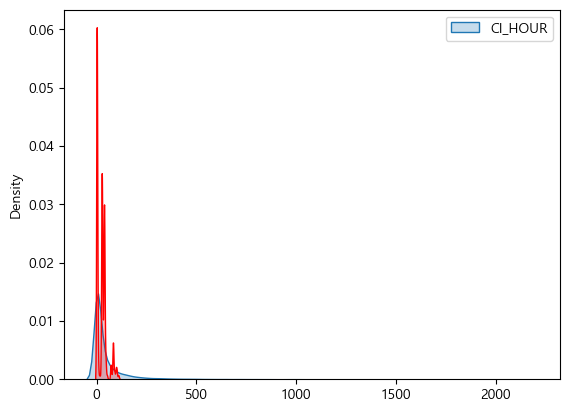

In [14]:
import seaborn as sns
sns.kdeplot(y_valid, color="red", shade=True)
sns.kdeplot(y_valid_pred, color="red", shade=True)

In [15]:
model_feature_importance = pd.DataFrame(
    {'feature' : model.feature_names_in_, 
     'importance' : model.feature_importances_}).sort_values(by='importance', ascending=False)

In [16]:
len(model_feature_importance)

8

In [17]:
model_feature_importance

,feature,importance
0,DIST,0.632676
6,ARI_PO,0.097738
4,SHIPMANAGER,0.070657
3,PORT_SIZE,0.057676
1,SHIP_TYPE_CATEGORY,0.039860
7,GT,0.038305
2,ARI_CO,0.035901
5,DEADWEIGHT,0.027187


In [18]:
len(model_feature_importance.loc[model_feature_importance['importance'] > 0, 'feature'])

8

In [19]:
model_feature_importance.loc[model_feature_importance['importance'] > 0, 'feature'].tolist()

['DIST',
 'ARI_PO',
 'SHIPMANAGER',
 'PORT_SIZE',
 'SHIP_TYPE_CATEGORY',
 'GT',
 'ARI_CO',
 'DEADWEIGHT']